#Implementation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv("dataset_phishing.csv",index_col=False)

In [3]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
df['target'] = pd.get_dummies(df['status'])['legitimate'].astype('int')
df.drop('status',axis = 1, inplace=True)
df[['url','target']].head(5)

,url,target
0,http://www.crestonwood.com/router.php,1
1,http://shadetreetechnology.com/V4/validation/a...,0
2,https://support-appleld.com.secureupdate.duila...,0
3,http://rgipt.ac.in,1
4,http://www.iracing.com/tracks/gateway-motorspo...,1


In [5]:
tmp = df.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]

,index,missing_val


In [6]:
df1 = pd.DataFrame(df)
df1 = df1.sample(n=10000)

In [7]:
from io import StringIO

In [8]:
col = ['target','url']
df1 = df1[col]
#Deleting nulls
df1 = df1[pd.notnull(df1['url'])]
#more settings for our data manipulation
df1.columns = ['target', 'url']
df1['category_id'] = df1['target'].factorize()[0]
category_id_df = df1[['target', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'target']].values)

In [9]:
import matplotlib.pyplot as plt

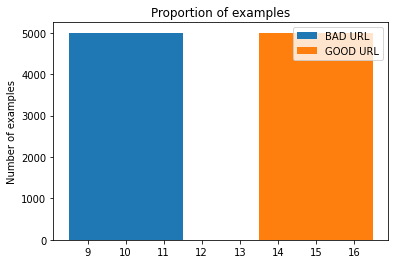

In [10]:
BAD_len = df1[df1['target'] == 0].shape[0]
GOOD_len = df1[df1['target'] == 1].shape[0]
plt.bar(10,BAD_len,3, label='BAD URL')
plt.bar(15,GOOD_len,3, label='GOOD URL')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

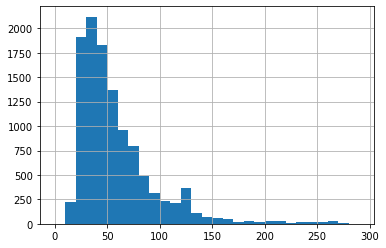

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
lens = df.url.str.len()
lens.hist(bins = np.arange(0,300,10))

In [12]:
#tokenizer function for URL by Faizan Ahmad, CEO FSecurify
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens=[]
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokentsByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    if 'com' in allTokens:
        allTokens.remove('com')
    return allTokens

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
y = [d[1]for d in df1] #labels
myUrls = [d[0]for d in df1] #urls
vectorizer = TfidfVectorizer( tokenizer=getTokens ,use_idf=True, smooth_idf=True, sublinear_tf=False)

In [15]:
features = vectorizer.fit_transform(df1.url).toarray()
target = df1.target
features.shape

(10000, 19352)

In [16]:
import pickle

pickle.dump(features, open("feat.pickle", "wb"))

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, target, df1.index, test_size=0.20, random_state=0)

In [18]:
df1.columns

Index(['target', 'url', 'category_id'], dtype='object')

###MLP churn

In [ ]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)

In [ ]:
#Define a batch size , 
bs = 64
#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)


#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [ ]:
n_input_dim = X_train.shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier


class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

model_churn = ChurnModel()
print(model_churn)

In [ ]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model_churn.parameters(), lr=learning_rate)
epochs = 50

In [ ]:
model_churn.train()
train_loss = []
for epoch in range(epochs):
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        y_pred = model_churn(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
    train_loss.append(loss.item())
print('Last iteration loss value: '+str(loss.item()))

In [ ]:
import itertools

y_pred_list = []
model_churn.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model_churn(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
y_true_test = y_test.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)

In [ ]:
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))

In [ ]:
X_predict = ["www.radsport-voggel.de/wp-admin/includes/log.exe"]
X_predict = vectorizer.transform(X_predict)

In [ ]:

X_predict = X_predict.toarray
#print(X_predict)

In [ ]:
type(X_predict)

In [ ]:
X_predict=X_predict.todense()
print(X_predict)

In [ ]:
X_predict.shape

In [ ]:
type(X_predict)

In [ ]:
okay =  torch.from_numpy(X_predict).float()
#okay = okay.unsqueeze(1)
predict = DataLoader(test_ds, batch_size=32)
#for i in predict:
 # y = model_churn(i)
  #print(y)

y = model_churn(okay)

In [ ]:
type(okay)

In [ ]:
okay.shape

In [ ]:
predict.shape

In [ ]:
tensor =  torch.from_numpy(X_predict).float()
tensor = tensor.unsqueeze(1)
test_ds = TensorDataset(tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

##Random

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest= RandomForestClassifier(max_depth = 5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [20]:
X_predict = ['https://medium.com/@ismaelbouarfa/malicious-url-detection-with-machine-learning-d57890443dec']
X_predict = vectorizer.transform(X_predict)
y_Predict = forest.predict(X_predict)
print(y_Predict)

[1]


In [22]:
import pickle
filename = 'model.sav'
pickle.dump(forest, open(filename, 'wb'))

In [23]:
loaded_model = pickle.load(open(filename, 'rb'))
y_Predict = forest.predict(X_predict)
print(y_Predict)

[1]


#MLP

In [ ]:
#Importing MLPClassifier
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=30,activation = 'relu',solver='adam',random_state=1)

In [ ]:
classifier.fit(X_train, y_train)

#TOOL

http://’www.radsport-voggel.de/wp-admin/includes/log.exe'@.php?

In [ ]:
import threading
from queue import Queue
import requests
import random
import sys
import socket
import time
from datetime import datetime
import pickle

def port_scanner(host_name):
    
    print_lock = threading.Lock()
    
    #Defining target
    try:
      target = socket.gethostbyname(host_name) #Translating hostname to IPv4
    except:
      print("[Errno -2] Name or service not known")

    #Adding a banner
    print("--" * 50)
    print("Starting Scan")
    print("Scanning Target " +target)
    print("Time Started :" +str(datetime.now()))
    print("--" * 50)

    print("\nScanning for Open Ports....")
        
    def pscan(port):
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        
        try:
            socket.setdefaulttimeout(2)
            result = s.connect_ex((target, port))
            with print_lock:
                if result == 0:
                    print("PORT {} IS OPEN".format(port))
            s.close()

        except KeyboardInterrupt:
            print("\n Exiting Program. ")
            sys.exit()

        except socket.gaierror:
            print("Hostname could not be resolved. ")
            sys.exit()
        
        except socket.error:
            print("Couldn't connect to server. ")
            sys.exit()

    def threader():
        while True:
            worker=q.get()
            pscan(worker)
            q.task_done()

    q= Queue()

    for x in range(50):
        t = threading.Thread(target=threader)
        t.daemon = True
        t.start()

    for worker in range(1,1000):
        q.put(worker)

    q.join()



def brute_force(website, urlp):
    
    url=urlp
    wordlist="Common.txt"
    ext=".php"

    try:
        target = socket.gethostbyname(website) #Translating hostname to IPv4

    except socket.gaierror:
        print("Hostname could not be resolved. ")
        sys.exit()
        
    except socket.error:
        print("Couldn't connect to server. ")
        sys.exit()

    #Adding a banner
    print("\nLooking for Directories....")
    
    fo = open(wordlist,"r+")
    for i in range(1000):
        word = fo.readline(10).strip()
        surl = url+word+ext
            
        response = requests.get(surl)
        if (response.status_code == 200):
            print ("[+] Found :- ",surl)
        else:
            pass


def subdomain(website):
    
    #Adding a banner
    print("\nEnumerating Subdomains....")
    
    subdomains = []

    req = requests.get(f'https://crt.sh/?q={website}&output=json')

    if req.status_code != 200:
        print('[*] Information not available!')
        sys.exit(1)

    for (key,value) in enumerate(req.json()):
        subdomains.append(value['name_value'])

    subs = sorted(set(subdomains))

    for s in subs:
        print(f'[*] {s}\n')
    

if __name__ == '__main__':

    while True:
        
        print("*" * 50)
        print('\n URL Reconnaissance Activated !\n')
        print("*" * 50)

        website= (input("Enter target Domain : "))
        url= (input("\nEnter target URL : "))
        #loaded = pickle.load(open("feat.pickle", 'rb'))
        #loaded_model = pickle.load(open("finalized_model.sav", 'rb'))
        predict =[url]
        predict = vectorizer.transform(predict)
        y_Predict = forest.predict(predict)
        if(y_Predict[0]==0):
          print("\nBAD URL")
        else:
            print("\nSAFE URL")
        #wordlist= (input("\nEnter brute force Wordlist : "))
        #extension= (input("\nEnter extension for Directory : "))

        try:
          port_scanner(website)
        except:
          print("ERROR : Couldn't scan")
        try:
          brute_force(website, url)
        except:
          print("ERROR : Invalid URL. No schema supplied")
        try:
          subdomain(website)
        except:
          print("ERROR : Couldn't retrieve subdomains")      
        print("--" *50)
        print("scan completed succesfully")
        print("Time Completed: " +str(datetime.now()))
        print("--" *50)

        print("\n")
        print("\nGood Bye ! \n")
        exit()

**************************************************

 URL Reconnaissance Activated !

**************************************************
Enter target Domain : http://’www.radsport-voggel.de/wp-admin/includes/log.exe'@.php?

Enter target URL : http://’www.radsport-voggel.de/wp-admin/includes/log.exe'@.php?

BAD URL
[Errno -2] Name or service not known
----------------------------------------------------------------------------------------------------
Starting Scan
ERROR : Couldn't scan
Hostname could not be resolved. 
ERROR : Invalid URL. No schema supplied

Enumerating Subdomains....
[*] Information not available!
ERROR : Couldn't retrieve subdomains
----------------------------------------------------------------------------------------------------
scan completed succesfully
Time Completed: 2022-05-12 09:17:30.494728
----------------------------------------------------------------------------------------------------



Good Bye ! 

**************************************************

 U